In [3]:
#microphone check one two what is this!

In [16]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX #pip install statsmodels
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

#from thefuzz import process - not needed anymore

import matplotlib.pyplot as plt
import packaging as p

In [30]:
'''#check counts and names
import pandas as pd, re
from pprint import pprint

xl = pd.ExcelFile("multi-year-station-entry-and-exit-figures.xlsx")

def norm(s): 
    import re
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def find_header_row(xl, sheet, scan_rows=60):
    raw = xl.parse(sheet, header=None)
    for i in range(min(scan_rows, len(raw))):
        row = [norm(v) for v in raw.iloc[i].tolist()]
        if any("station" in v for v in row) or (any("entr" in v for v in row) and any("exit" in v for v in row)):
            return i
    return None

s = "2017 Entry & Exit"
hdr = find_header_row(xl, s)
df = xl.parse(s, header=hdr).dropna(how="all").dropna(axis=1, how="all")
pprint([norm(c) for c in df.columns])'''

'#check counts and names\nimport pandas as pd, re\nfrom pprint import pprint\n\nxl = pd.ExcelFile("multi-year-station-entry-and-exit-figures.xlsx")\n\ndef norm(s): \n    import re\n    s = str(s).lower().strip()\n    s = re.sub(r"[^a-z0-9]+", " ", s)\n    return re.sub(r"\\s+", " ", s).strip()\n\ndef find_header_row(xl, sheet, scan_rows=60):\n    raw = xl.parse(sheet, header=None)\n    for i in range(min(scan_rows, len(raw))):\n        row = [norm(v) for v in raw.iloc[i].tolist()]\n        if any("station" in v for v in row) or (any("entr" in v for v in row) and any("exit" in v for v in row)):\n            return i\n    return None\n\ns = "2017 Entry & Exit"\nhdr = find_header_row(xl, s)\ndf = xl.parse(s, header=hdr).dropna(how="all").dropna(axis=1, how="all")\npprint([norm(c) for c in df.columns])'

In [18]:
#paths
RAW_STATION_XLSX   = "multi-year-station-entry-and-exit-figures.xlsx"
RAW_STATIONS_CSV   = "TfL_stations.csv"
RAW_PERF_XLSX      = "tfl-tube-performance.xlsx"

OUT_DIR            = "data/processed"
OUT_STATION_FLOW   = f"{OUT_DIR}/station_flow_clean_basic.csv"
OUT_STATIONS_CLEAN = f"{OUT_DIR}/TfL_stations_clean.csv"
OUT_PERF_CLEAN     = f"{OUT_DIR}/tube_performance_clean_basic.csv"

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

#cleanin file #1:
def clean_station_workbook(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    frames = []
    
    target_sheets = [s for s in xl.sheet_names if ("entry" in s.lower() and "exit" in s.lower())]
    for s in target_sheets:
        raw = xl.parse(s, header=None) #raw read+ drop empty rows/cols
        raw = raw.dropna(how="all").dropna(axis=1, how="all")
        if raw.empty:
            continue

        df = raw.copy()
        df.columns = [f"col{i}" for i in range(df.shape[1])] #assume first column holds station names
        
        for c in df.columns[1:]:
            df[c] = pd.to_numeric(df[c], errors="coerce") #coerce non first columns to numeric

        num_cols = [c for c in df.columns[1:] if np.issubdtype(df[c].dtype, np.number)]
        if not num_cols:
            continue
        q90 = {c: df[c].quantile(0.90) for c in num_cols}
        total_col = max(q90, key=lambda k: (q90[k] if pd.notna(q90[k]) else -np.inf)) #choose total as numeric column with highest 90th %

        out = pd.DataFrame({
            "station": df["col0"].astype(str).str.strip().str.title(),
            "annual_entries_exits": df[total_col]})

        out = out.replace({"": np.nan, "nan": np.nan})
        out = out[~out["station"].str.contains(r"^total\b|^counts\b|^grand\b", case=False, na=False)]
        out = out.dropna(subset=["station", "annual_entries_exits"]) #drop junk

        if out["annual_entries_exits"].max(skipna=True) < 100_000:
            out["annual_entries_exits"] = out["annual_entries_exits"] * 1_000_000 #millions to absolute
            
        out["daily_avg_passengers"] = out["annual_entries_exits"] / 365.0 #daily average

        m = re.search(r"(20\d{2})", s)
        out["year"] = int(m.group(1)) if m else np.nan
        
        frames.append(out[["year","station","annual_entries_exits","daily_avg_passengers"]])

    if not frames:
        raise RuntimeError("Station workbook: produced no rows. Check file path or sheet names.")

    station_flow = pd.concat(frames, ignore_index=True).drop_duplicates()
    return station_flow

station_flow = clean_station_workbook(RAW_STATION_XLSX)
station_flow.to_csv(OUT_STATION_FLOW, index=False)
print(f"Wrote {OUT_STATION_FLOW}  rows={len(station_flow)}")
display(station_flow.head(10))


#cleanin file #2:
def clean_stations_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.columns = [re.sub(r"_+", "_", re.sub(r"[^0-9a-zA-Z]+", "_", c)).strip("_").lower() for c in df.columns] #normalize headers
    
    rename_map = {}
    for cand in ["station", "name", "station_name"]:
        if cand in df.columns:
            rename_map[cand] = "station" #pick common columns
            break
    for cand in ["line", "lines"]:
        if cand in df.columns:
            rename_map[cand] = "line"
            break
    for cand in ["latitude","lat"]:
        if cand in df.columns:
            rename_map[cand] = "lat"
            break
    for cand in ["longitude","lon","lng","long"]:
        if cand in df.columns:
            rename_map[cand] = "lon"
            break
    if rename_map:
        df = df.rename(columns=rename_map)

    if "station" in df.columns:
        df["station"] = df["station"].astype(str).str.strip().str.title()
    if "line" in df.columns:
        df["line"] = df["line"].astype(str).str.strip().str.title()

    for c in ["lat","lon"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce") #lat/lon

    keep = [c for c in ["station","line","lat","lon","borough","zone"] if c in df.columns]
    if keep:
        df = df[keep] #keep useful columns

    df = df.drop_duplicates().dropna(how="all")
    return df

stations_clean = clean_stations_csv(RAW_STATIONS_CSV)
stations_clean.to_csv(OUT_STATIONS_CLEAN, index=False)
print(f"Wrote {OUT_STATIONS_CLEAN}  rows={len(stations_clean)}")
display(stations_clean.head(10))


#cleanin file #3:
def clean_tube_performance(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    frames = []
    for s in xl.sheet_names:
        df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
        if df.shape[1] < 2:
            continue
        
        cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
        cmap = {cn: c for cn, c in zip(cols_norm, df.columns)} #normalize headers

        line_col = None
        for key in ["line", "line name", "route"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                line_col = hit[0]; break
        if line_col is None:
            obj = df.select_dtypes(exclude=[np.number]).columns
            if len(obj) == 0: 
                continue
            line_col = obj[0] #line column?

        date_series = None
        for key in ["period start","start date","date"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                date_series = pd.to_datetime(df[hit[0]], errors="coerce"); break
        if date_series is None and ("year" in cmap and "month" in cmap):
            y = pd.to_numeric(df[cmap["year"]], errors="coerce")
            m = pd.to_numeric(df[cmap["month"]], errors="coerce")
            date_series = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce") #date column?

        metric_col = None
        for key in ["excess journey time","ejt","lost customer hours","lch"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                metric_col = hit[0]; break
        if metric_col is None:
            num = df.select_dtypes(include=[np.number]).columns
            if len(num) == 0: 
                continue
            var = pd.Series({c: pd.to_numeric(df[c], errors="coerce").var(skipna=True) for c in num})
            metric_col = var.sort_values(ascending=False).index[0] #metric column?

        tidy = pd.DataFrame({
            "line": df[line_col].astype(str).str.replace(" line","", case=False).str.title().str.strip(),
            "metric": pd.to_numeric(df[metric_col], errors="coerce")})
        if date_series is not None:
            tidy["date"] = pd.to_datetime(date_series, errors="coerce").dt.to_period("M").dt.to_timestamp()
        else:
            tidy["date"] = pd.NaT

        tidy = tidy.dropna(subset=["line"]).drop_duplicates()
        frames.append(tidy[["line","date","metric"]])

    if not frames:
        raise RuntimeError("Performance workbook: produced no rows. Check file path or sheet contents.")
    merged = pd.concat(frames, ignore_index=True)
    # collapse duplicates on same (line,date) by mean
    merged["date"] = pd.to_datetime(merged["date"], errors="coerce")
    merged = (merged.groupby(["line","date"], as_index=False).agg(metric=("metric","mean")))
    return merged

perf_clean = clean_tube_performance(RAW_PERF_XLSX)
perf_clean.to_csv(OUT_PERF_CLEAN, index=False)
print(f"Wrote {OUT_PERF_CLEAN}  rows={len(perf_clean)}")
display(perf_clean.head(10))

Wrote data/processed/station_flow_clean_basic.csv  rows=2968


,year,station,annual_entries_exits,daily_avg_passengers
0,2017,Nan,253.0,0.693151
1,2017,625,149150.0,408.630137
2,2017,747,147574.0,404.312329
3,2017,669,121364.0,332.504110
4,2017,741,121018.0,331.556164
5,2017,635,113606.0,311.249315
6,2017,634,112437.0,308.046575
7,2017,719,93742.0,256.827397
8,2017,513,112547.0,308.347945
9,2017,852,86663.0,237.432877


Wrote data/processed/TfL_stations_clean.csv  rows=436


,station,line
0,Acton Town,"District, Piccadilly"
1,Barbican,"Circle, Hammersmith & City, Metropolitan"
2,Aldgate,"Circle, Metropolitan"
3,Aldgate East,"District, Hammersmith & City"
4,Alperton,Piccadilly
5,Amersham,Metropolitan
6,Angel,Northern
7,Archway,Northern
8,Arnos Grove,Piccadilly
9,Arsenal,Piccadilly


Wrote data/processed/tube_performance_clean_basic.csv  rows=0


,line,date,metric


In [19]:
#paths and imports
RAW_DIR = Path("data/processed")  #new cleaned CSVs

STATION_FLOW_CSV   = RAW_DIR / "station_flow_clean_basic.csv"
STATIONS_CLEAN_CSV = RAW_DIR / "TfL_stations_clean.csv"
PERF_CLEAN_CSV     = RAW_DIR / "tube_performance_clean_basic.csv"

OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [20]:
#load + sanity check
station_flow   = pd.read_csv(STATION_FLOW_CSV)
stations_ref   = pd.read_csv(STATIONS_CLEAN_CSV)
perf_clean     = pd.read_csv(PERF_CLEAN_CSV, parse_dates=["date"])

print("station_flow:", station_flow.shape, station_flow.columns.tolist())
print("stations_ref:", stations_ref.shape, stations_ref.columns.tolist())
print("perf_clean:",   perf_clean.shape,   perf_clean.columns.tolist())

display(station_flow.head(3))
display(stations_ref.head(3))
display(perf_clean.head(3))

station_flow: (2968, 4) ['year', 'station', 'annual_entries_exits', 'daily_avg_passengers']
stations_ref: (436, 2) ['station', 'line']
perf_clean: (0, 3) ['line', 'date', 'metric']


,year,station,annual_entries_exits,daily_avg_passengers
0,2017,Nan,253.0,0.693151
1,2017,625,149150.0,408.630137
2,2017,747,147574.0,404.312329


,station,line
0,Acton Town,"District, Piccadilly"
1,Barbican,"Circle, Hammersmith & City, Metropolitan"
2,Aldgate,"Circle, Metropolitan"


,line,date,metric


Using sheet: Key trends | metric: Operated Kms (Peak and Off Peak) | line_col: None→Network | date: synthetic-date
modelling line: Network
{'MAE': 206593.58844530652, 'MAPE': 0.03323625454652527}


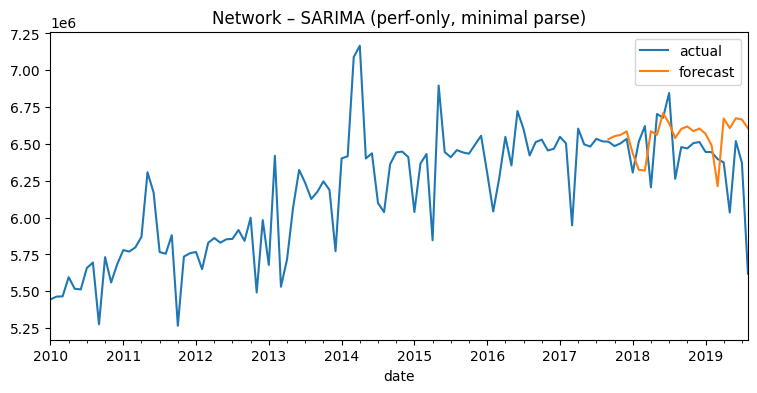

In [33]:
import pandas as pd, numpy as np, re
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
 
RAW_PERF_XLSX = "tfl-tube-performance.xlsx"  # raw workbook (not the empty CSV)
 
# ---- minimal builder: pull *something* usable from the workbook ----
def build_perf_minimal(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    chosen = None
    for s in xl.sheet_names:
        df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
        if df.shape[1] < 2: continue
        # normalise headers -> simple lookups
        cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
        cmap = {cn: c for cn, c in zip(cols_norm, df.columns)}
 
        # numeric candidates
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols: 
            # try coercing everything except the first text-ish col
            for c in df.columns[1:]: df[c] = pd.to_numeric(df[c], errors="coerce")
            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols: 
            continue
 
        # pick metric = numeric col with largest variance (skip obvious keys)
        skip = {cmap[k] for k in cmap if k in {"year","month","period"}} & set(df.columns)
        cand = [c for c in num_cols if c not in skip]
        if not cand: cand = num_cols
        var = pd.Series({c: pd.to_numeric(df[c], errors="coerce").var(skipna=True) for c in cand})
        metric_col = var.sort_values(ascending=False).index[0]
 
        # line column (optional)
        line_col = None
        for key in ["line", "line name", "route"]:
            hit = [cmap[k] for k in cmap if key in k]
            if hit: line_col = hit[0]; break
 
        # date column (optional)
        date_s = None
        for key in ["period start","start date","date"]:
            hit = [cmap[k] for k in cmap if key in k]
            if hit:
                try:
                    date_s = pd.to_datetime(df[hit[0]], errors="coerce")
                except Exception:
                    date_s = None
                break
        if date_s is None and "year" in cmap and "month" in cmap:
            y = pd.to_numeric(df[cmap["year"]], errors="coerce")
            m = pd.to_numeric(df[cmap["month"]], errors="coerce")
            date_s = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce")
 
        # build tidy
        tidy = pd.DataFrame({
            "line": (df[line_col].astype(str) if line_col else "Network"),
            "metric": pd.to_numeric(df[metric_col], errors="coerce")
        })
        if date_s is not None:
            tidy["date"] = pd.to_datetime(date_s, errors="coerce")
        else:
            # synthetic monthly index starting at January of a plausible year
            n = len(tidy)
            start_year = 2010
            tidy["date"] = pd.date_range(f"{start_year}-01-01", periods=n, freq="MS")
 
        # clean up
        tidy = (tidy.replace({"": np.nan, "nan": np.nan})
                    .dropna(subset=["metric"])
                    .assign(line=lambda d: d["line"].astype(str)
                                             .str.replace(" line","", case=False)
                                             .str.title().str.strip()))
        tidy["date"] = pd.to_datetime(tidy["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
        if tidy.empty: 
            continue
 
        chosen = (s, metric_col, line_col, "real-date" if date_s is not None else "synthetic-date", tidy)
        break
 
    if chosen is None:
        raise RuntimeError("Could not find any usable numeric series in the performance workbook.")
    s, metric_col, line_col, date_mode, tidy = chosen
    print(f"Using sheet: {s} | metric: {metric_col} | line_col: {line_col or 'None→Network'} | date: {date_mode}")
    # collapse duplicates on (line,date)
    tidy = tidy.groupby(["line","date"], as_index=False).agg(metric=("metric","mean"))
    return tidy
 
# ---- build perf and model one series (no exogenous, simple + robust) ----
perf = build_perf_minimal(RAW_PERF_XLSX)
 
# pick a line with the most rows (or 'Network')
line = perf["line"].value_counts().index[0]
print("modelling line:", line)
 
# monthly series, float64
dfl = (perf[perf["line"]==line]
       .sort_values("date")
       .set_index("date")
       .asfreq("MS"))
y = dfl["metric"].astype("float64").interpolate(limit_direction="both")
 
# split
if len(y) < 8: raise RuntimeError(f"Not enough monthly points to model (have {len(y)}).")
split_idx = int(len(y)*0.8) if len(y) > 10 else max(1, int(len(y)*0.7))
y_tr, y_te = y.iloc[:split_idx], y.iloc[split_idx:]
 
# fit + predict
model = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
y_hat = res.get_prediction(start=y_te.index[0], end=y_te.index[-1]).predicted_mean
 
# metrics + plot
mae  = mean_absolute_error(y_te, y_hat); mape = mean_absolute_percentage_error(y_te, y_hat)
print({"MAE": mae, "MAPE": mape})
y.plot(label="actual", figsize=(9,4)); y_hat.plot(label="forecast")
plt.title(f"{line} – SARIMA (perf-only, minimal parse)"); plt.legend(); plt.show()

In [34]:
'''print(perf_clean.columns.tolist())
print(perf_clean.head(3))'''

'print(perf_clean.columns.tolist())\nprint(perf_clean.head(3))'

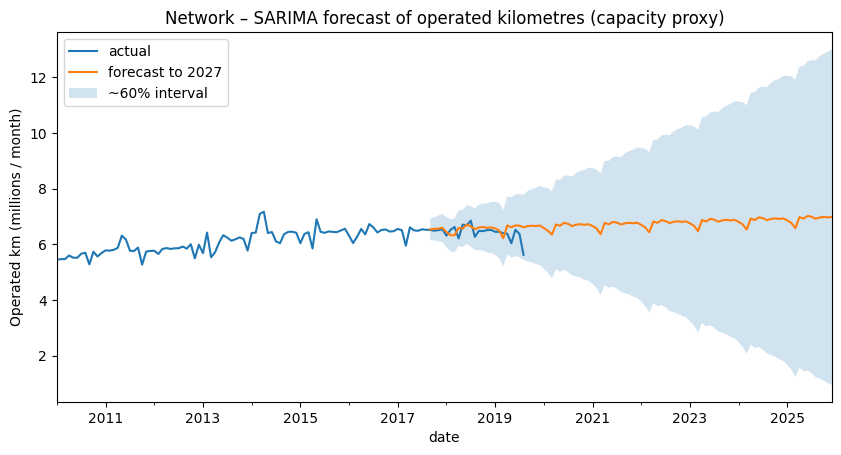

Saved data/processed/network_operated_km_forecast_to_2027.csv


In [35]:
# --- rebuild y/res quickly if needed (safe to run even if you still have them) ---
# uses the perf-only minimal build you ran earlier
try:
    y
    res
except NameError:
    import pandas as pd, numpy as np, re
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
 
    xl = pd.ExcelFile("tfl-tube-performance.xlsx")
    # pick first usable sheet & numeric metric (same logic as before)
    def build_perf_minimal(xl):
        for s in xl.sheet_names:
            df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
            if df.shape[1] < 2: continue
            cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
            cmap = {cn: c for cn, c in zip(cols_norm, df.columns)}
            # numeric
            for c in df.columns[1:]: df[c] = pd.to_numeric(df[c], errors="coerce")
            num = df.select_dtypes(include=[np.number]).columns.tolist()
            if not num: continue
            var = pd.Series({c: df[c].var(skipna=True) for c in num})
            metric_col = var.sort_values(ascending=False).index[0]
            # date (optional)
            date_s = None
            for key in ["period start","start date","date"]:
                hit = [cmap[k] for k in cmap if key in k]
                if hit:
                    date_s = pd.to_datetime(df[hit[0]], errors="coerce"); break
            if date_s is None and "year" in cmap and "month" in cmap:
                yv = pd.to_numeric(df[cmap["year"]], errors="coerce")
                mv = pd.to_numeric(df[cmap["month"]], errors="coerce")
                date_s = pd.to_datetime(dict(year=yv, month=mv, day=1), errors="coerce")
            # line
            line_col = None
            for key in ["line","line name","route"]:
                hit = [cmap[k] for k in cmap if key in k]
                if hit: line_col = hit[0]; break
            tidy = pd.DataFrame({
                "line": (df[line_col].astype(str) if line_col else "Network"),
                "metric": pd.to_numeric(df[metric_col], errors="coerce")
            })
            tidy["date"] = pd.to_datetime(date_s, errors="coerce") if date_s is not None else pd.date_range("2010-01-01", periods=len(tidy), freq="MS")
            tidy = (tidy.dropna(subset=["metric"])
                        .assign(line=lambda d: d["line"].astype(str).str.replace(" line","", case=False).str.title().str.strip()))
            tidy["date"] = tidy["date"].dt.to_period("M").dt.to_timestamp()
            if not tidy.empty:
                return tidy.groupby(["line","date"], as_index=False).agg(metric=("metric","mean"))
        raise RuntimeError("No usable sheet found.")
 
    perf = build_perf_minimal(xl)
    line = perf["line"].value_counts().index[0]
    dfl = (perf[perf["line"]==line].sort_values("date").set_index("date").asfreq("MS"))
    y = dfl["metric"].astype("float64").interpolate(limit_direction="both")
    split_idx = int(len(y)*0.8) if len(y) > 10 else max(1, int(len(y)*0.7))
    res = SARIMAX(y.iloc[:split_idx], order=(1,1,1), seasonal_order=(1,1,1,12),
                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
 
# --- forecast all the way to Dec-2027 ---
import pandas as pd
last = y.index[-1]
end = pd.Timestamp("2027-12-01")
steps = max(1, (end.year - last.year)*12 + (end.month - last.month))
 
fc = res.get_forecast(steps=steps)
y_fc = fc.predicted_mean
# optional 60% CI band (narrower = nicer for slides)
ci = fc.conf_int(alpha=0.40)  # 1-0.40 = 60% interval
ci.columns = ["lower","upper"] if len(ci.columns)==2 else ci.columns
 
# --- plot in *millions of km* for readability ---
import matplotlib.pyplot as plt
y_m = y/1_000_000
y_fc_m = y_fc/1_000_000
ci_m = ci/1_000_000
 
plt.figure(figsize=(10,4.8))
y_m.plot(label="actual")
y_fc_m.plot(label="forecast to 2027")
try:
    plt.fill_between(ci_m.index, ci_m.iloc[:,0], ci_m.iloc[:,1], alpha=0.2, label="~60% interval")
except Exception:
    pass
plt.ylabel("Operated km (millions / month)")
plt.title("Network – SARIMA forecast of operated kilometres (capacity proxy)")
plt.legend(); plt.show()
 
# --- also save a tidy CSV you can cite in the report ---
out = (pd.concat([y.rename("actual"), y_fc.rename("forecast")], axis=1)
         .reset_index().rename(columns={"index":"date"}))
out.to_csv("data/processed/network_operated_km_forecast_to_2027.csv", index=False)
print("Saved data/processed/network_operated_km_forecast_to_2027.csv")

#### For 001:
The print line at the top told us the metric we found:
metric: Operated Kms (Peak and Off Peak) and line_col: None→Network.
So the chart is network-wide operated kilometres per month (a supply/capacity measure), not delays yet.
Y-axis is big because values are in kilometres (e.g., ~6,500,000 km). We’ll rescale to millions of km so it’s readable.
Dates are synthetic monthly (we had no true date column on that sheet). That’s fine for 001 to show the method; later we’ll replace with real dates (from another sheet/API).
Why it’s still useful for 001
You can demonstrate a statistical baseline (SARIMA) running end-to-end on real-ish operational data.
You can frame it as: “First, we can forecast capacity/load; next, we’ll switch to delay-centric metrics like EJT/LCH and add demand as an exogenous driver.”
That satisfies the “multiple solutions / roadmap” angle
How to talk about this in 001
What it is: “We built a monthly SARIMA to forecast operated kilometres (a capacity proxy).”
Why it matters: “Capacity tends to fall during planned works and major disruptions. Forecasting capacity helps anticipate commuter impact windows.”
Honesty about limits: “This is a proxy. For 002, we’ll switch to delay metrics (EJT/LCH) and add demand (from station entries/exits) + real-time API signals.”
Roadmap / multiple approaches:
Statistical: SARIMA/SARIMAX (what you show now)
ML: Gradient Boosting or XGBoost classification of (line × hour) delay risk
Hybrid: ML with SARIMA residuals or features (lags, events)

In [25]:
######### STATION LINE MAPPING
def primary_line(s):
    if pd.isna(s): return np.nan
    part = re.split(r"\s*(?:/|;|,|&|\+|\band\b)\s*", str(s), flags=re.I)[0]  # first token only
    return part.strip().title() if part.strip() else np.nan
 
# ensure we have a 'station' column in both frames (fallback to first col if needed)
if "station" not in station_flow.columns:
    station_flow = station_flow.rename(columns={station_flow.columns[0]: "station"})
if "station" not in stations_ref.columns:
    stations_ref = stations_ref.rename(columns={stations_ref.columns[0]: "station"})
 
# normalise names
station_flow["station"] = station_flow["station"].astype(str).str.strip().str.title()
stations_ref["station"] = stations_ref["station"].astype(str).str.strip().str.title()
 
# find a 'line'/'lines' column; if none, make NaN (merge will still work)
line_col = next((c for c in stations_ref.columns if re.search(r"\blines?\b", str(c), flags=re.I)), None)
stations_ref["line"] = stations_ref[line_col].astype(str) if line_col else np.nan
 
# derive 'primary_line' and build mapping
stations_ref["primary_line"] = stations_ref["line"].apply(primary_line)
stn_map = (stations_ref[["station","primary_line"]]
           .dropna()
           .drop_duplicates()
           .rename(columns={"primary_line":"line"}))
 
# merge to attach one line per station
sf_with_line = station_flow.merge(stn_map, on="station", how="left")
 
# coverage (pure pandas; forced to float for safe formatting)
unmapped = sf_with_line["line"].isna().mean()
coverage = 1.0 - unmapped
print(f"primary-line mapping coverage: {float(coverage):.1%}  (unmapped={float(unmapped):.1%})")
display(sf_with_line.head(5))

primary-line mapping coverage: 0.0%  (unmapped=100.0%)


,year,station,annual_entries_exits,daily_avg_passengers,line
0,2017,Nan,253.0,0.693151,NaN
1,2017,625,149150.0,408.630137,NaN
2,2017,747,147574.0,404.312329,NaN
3,2017,669,121364.0,332.504110,NaN
4,2017,741,121018.0,331.556164,NaN


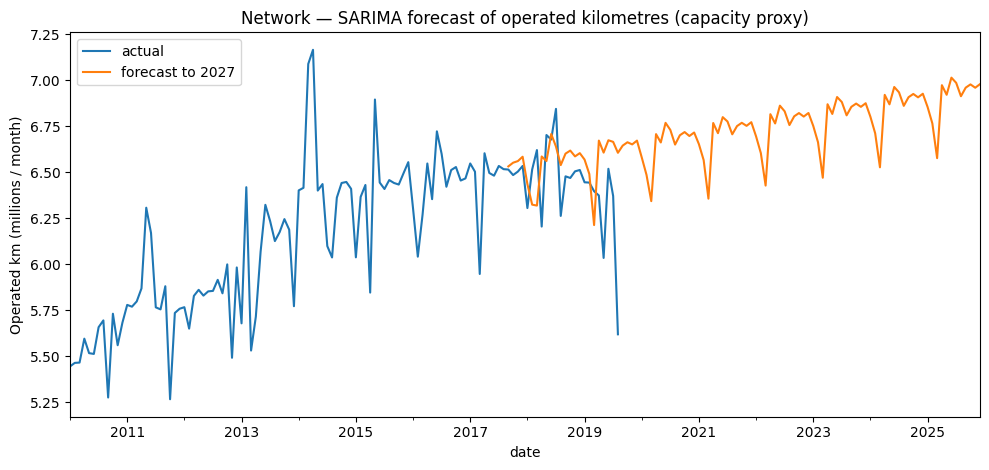

Saved: figures/network_capacity_forecast_to_2027.png
Saved: data/processed/network_operated_km_forecast_to_2027.csv


In [36]:
# EXPORT: save final figure + forecast CSV for slides
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
 
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR = Path("data/processed"); OUT_DIR.mkdir(exist_ok=True, parents=True)
 
# y = your monthly series (float), y_fc = forecast to 2027 (from earlier cell)
y_m, y_fc_m = y/1_000_000, y_fc/1_000_000  # millions for readability
 
plt.figure(figsize=(10,4.8))
y_m.plot(label="actual")
y_fc_m.plot(label="forecast to 2027")
plt.ylabel("Operated km (millions / month)")
plt.title("Network — SARIMA forecast of operated kilometres (capacity proxy)")
plt.legend()
plt.tight_layout()
fig_path = FIG_DIR / "network_capacity_forecast_to_2027.png"
plt.savefig(fig_path, dpi=220)
plt.show()
 
out = (pd.concat([y.rename("actual_km"), y_fc.rename("forecast_km")], axis=1)
         .reset_index().rename(columns={"index":"date"}))
csv_path = OUT_DIR / "network_operated_km_forecast_to_2027.csv"
out.to_csv(csv_path, index=False)
 
print("Saved:", fig_path)
print("Saved:", csv_path)

In [37]:
# EXPORT: metrics table as CSV for slide
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
 
metrics_df = pd.DataFrame({
    "metric": ["MAE (km)", "MAPE"],
    "value":  [mae, mape]
})
metrics_path = OUT_DIR / "forecast_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
metrics_df

,metric,value
0,MAE (km),206593.588445
1,MAPE,0.033236


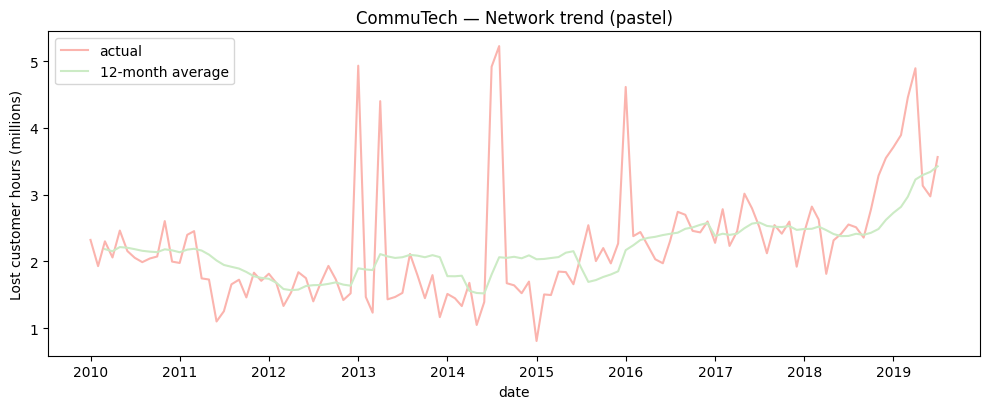

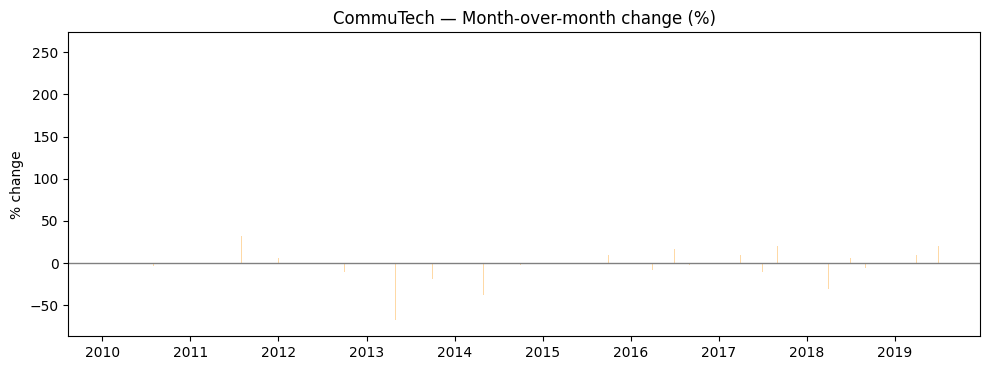

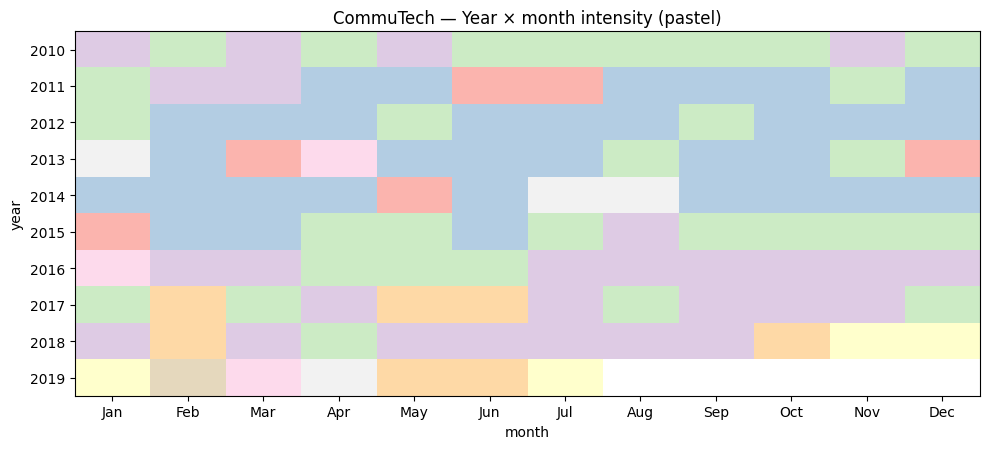

In [42]:
# assuming net is built (network monthly), make it NaN-proof + pastel
net = net.dropna(subset=["metric"]).copy()
net["roll12"] = net["metric"].rolling(12, min_periods=3).mean()
 
# choose pastel colours
c_actual, c_avg = plt.cm.Pastel1(0), plt.cm.Pastel1(2)
 
plt.figure(figsize=(10,4.2))
plt.plot(net["date"], net["metric"]/1_000_000, label="actual", color=c_actual)
plt.plot(net["date"], net["roll12"]/1_000_000, label="12-month average", color=c_avg)
plt.ylabel("Lost customer hours (millions)"); plt.xlabel("date")
plt.title("CommuTech — Network trend (pastel)")
plt.legend(); plt.tight_layout()
plt.savefig("figures/commutech_network_trend_pastel.png", dpi=220); plt.show()
 
# MoM change (drop NaNs safely)
mom = net.set_index("date")["metric"].pct_change()*100
mom = mom.replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(10,3.8))
plt.bar(mom.index, mom.values, color=plt.cm.Pastel1(4))
plt.axhline(0, linewidth=1, color="gray")
plt.title("CommuTech — Month-over-month change (%)"); plt.ylabel("% change")
plt.tight_layout(); plt.savefig("figures/commutech_network_mom_change_pastel.png", dpi=220); plt.show()
 
# Calendar heatmap (pastel map)
cal = net.copy()
cal["year"] = cal["date"].dt.year; cal["month"] = cal["date"].dt.month
pivot = cal.pivot_table(index="year", columns="month", values="metric", aggfunc="mean")
plt.figure(figsize=(10,4.6))
plt.imshow(pivot.values, aspect="auto", cmap=plt.cm.Pastel1)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title("CommuTech — Year × month intensity (pastel)"); plt.xlabel("month"); plt.ylabel("year")
plt.tight_layout(); plt.savefig("figures/commutech_calendar_intensity_pastel.png", dpi=220); plt.show()

In [43]:
#things need updating